In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy


class Normalizer:
    """
    The Great Normalizer
    """
    mins: np.ndarray
    maxs: np.ndarray
    span: np.ndarray
    mids: np.ndarray

    def __init__(self, reference_inputs: np.ndarray):
        self.mins = np.min(reference_inputs, 0)
        self.maxs = np.max(reference_inputs, 0)
        self.span = self.maxs - self.mins
        # mids = span / 2 + mins
        # and thus:
        # mids = (maxs + mins) / 2
        self.mids = (self.maxs + self.mins) / 2

    def scale(self, set: np.ndarray):
        # k0 = (reference_inputs[0] - mids) / (span / 2)
        # and thus:
        # k0 = 2*(reference_inputs[0] - mids) / span
        return 2 * np.subtract(set, self.mids) / self.span

def sig(x):
    return 1 / (1 + np.exp(-x))


def shp(n: np.ndarray):
    return n.reshape((-1, n.shape[-1]))


def val(x: np.ndarray, w, b):
    """
    input:
        `N`[1...inf) input rows(M,)
    return:
        `2D(N,M)` arr of predictions
    """
    return shp(np.dot(w, x.T)).T + b  # w is applied to N[1...inf) rows of x. Result: 2D(N, M) arr of predictions


def pred(x, w, b):
    return sig(val(x, w, b))


def polynom(inputs: np.ndarray, degree=6):
    if degree < 2:
        raise Exception("Degree should be at least 2")

    transposed = inputs.T
    base = len(transposed)

    pols = []
    newgen = []
    for i in range(base):
        newgen.append([i])
    pols.extend(newgen)

    for deg in range(1, degree):
        lastgen = newgen
        newgen = []
        for p in lastgen:
            for i in range(p[-1], base):
                pnext = [*p, i]
                pnext.sort()
                newgen.append(pnext)
        pols.extend(newgen)

    new_inputs = []
    for p in pols:
        new_inputs.append(deepcopy(transposed[p[0]]))
        for i in p[1:]:
            new_inputs[-1] *= transposed[i]
    return np.array(new_inputs).T

dataset = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 0],
    [1, 0, 0],
    [1, 1, 0],
    [1, 2, 1],
    [1, 3, 1],
    [1, 4, 1],
    [2, 0, 0],
    [2, 1, 0],
    [2, 2, 1],
    [2, 3, 1],
    [2, 4, 1],
    [3, 0, 0],
    [3, 1, 1],
    [3, 2, 1],
    [3, 3, 1],
    [3, 4, 1],
    [4, 0, 0],
    [4, 1, 1],
    [4, 2, 1],
    [4, 3, 1],
    [4, 4, 1],
])
x_train = polynom(dataset[:, :-1])
normer = Normalizer(x_train)
x_train = normer.scale(x_train)
y_train = dataset[:, -1:]
w = np.zeros((y_train.shape[-1],x_train.shape[-1]))
# w = list(range(5))
b = 0


def setplot():
    smols = np.array([x for x in dataset if x[-1] == 0])
    highs = np.array([x for x in dataset if x[-1] == 1])
    plt.scatter(smols[:, 0], smols[:, 1])
    plt.scatter(highs[:, 0], highs[:, 1], c='red')
    plt.show()


def checkplot():
    check_set = []
    for i in np.arange(0, 4, 0.1):
        for j in np.arange(0, 4, 0.1):
            check_set.append([np.round(i, 1), np.round(j, 1)])
    check_set = np.array(check_set)
    check_set_scaled = normer.scale(polynom(check_set))
    preds = pred(check_set_scaled, w, b)
    check_set = np.hstack((check_set, preds))
    smols = np.array([x for x in check_set if x[-1] >= 0.5])
    highs = np.array([x for x in check_set if x[-1] < 0.5])
    if len(smols) > 0:
        plt.scatter(smols[:, 0], smols[:, 1])
    if len(highs) > 0:
        plt.scatter(highs[:, 0], highs[:, 1], c='red')
    plt.show()


def cost(f, y):
    # print(f)
    if np.any(f == 1) or np.any(f == 0):
        return "NAN"
    a = y * np.log(f)
    b = (1 - y) * np.log(1 - f)
    return -np.mean(a+b)


def gradient(x, w, b, y):
    f = pred(x, w, b)
    err = f - y
    gw = np.dot(err.T, x) / len(err)
    gb = np.mean(err)
    return gw, gb


def checkplot2Dheatmap(axes=None,fig=None,hfig=None):
    check_set = []
    rng = np.arange(0, 4 + 0.1, 0.1).round(1)
    for i in rng:
        for j in rng:
            check_set.append([np.round(i, 1), np.round(j, 1)])
    check_set = np.array(check_set)
    check_set_scaled = normer.scale(polynom(check_set))
    preds = pred(check_set_scaled, w, b)
    check_set = np.hstack((check_set, preds))

    index = 0
    resultmap = np.zeros((len(rng), len(rng)))
    for i in range(len(rng)):
        for j in range(len(rng)):
            resultmap[i,j] = check_set[index, -1]
            index += 1

    if axes == None or fig==None or hfig==None:
        fig = plt.figure()
        axes = fig.add_subplot()
        hfig = display(fig, display_id=True)
    else:
        axes.cla()
    axes.imshow(resultmap, origin="lower")
    axes.set_yticks(np.arange(len(rng)), labels=rng)
    axes.set_xticks(np.arange(len(rng)), labels=rng)
    smols = np.array([x for x in dataset if x[-1] == 0])
    highs = np.array([x for x in dataset if x[-1] == 1])
    axes.scatter(smols[:, 0]*10, smols[:, 1]*10)
    axes.scatter(highs[:, 0]*10, highs[:, 1]*10, c='red')
    axes.locator_params(nbins=10)
    fig.canvas.draw()
    hfig.update(fig)
    return axes,fig,hfig



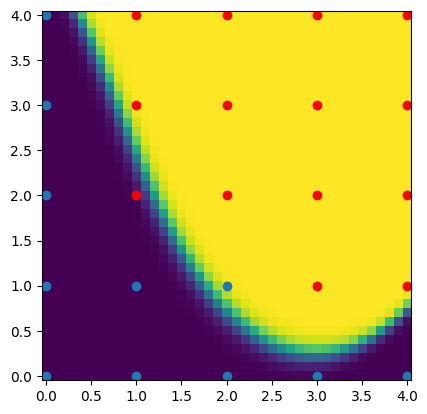

NAN: 100%|██████████| 100000/100000 [01:08<00:00, 1465.70it/s]                


In [5]:
from tqdm import tqdm
from time import sleep
import sys
%matplotlib inline
axes, fig, hfig = checkplot2Dheatmap()
with tqdm(range(10000), file=sys.stdout) as pbar:
    for i in pbar:
        # sleep(0.1)
        gw, gb = gradient(x_train, w, b, y_train)
        w -= 0.2*gw
        b -= 0.2*gb
        pbar.set_description(f"{cost(pred(x_train, w, b), y_train)}")
        if i%5000 == 0:
            axes,fig,hfig = checkplot2Dheatmap(axes, fig, hfig)
plt.close(fig)
